# Personal Data
Please fill in your details below to help us keep track of your submission.

Student Name: `Fatemeh Hamdi`

Student ID: `401105848`

# Part1: Perceptron(65 points)

## Imports

In [113]:
import pylab
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
import numpy as np
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

# pick the seed for reproducability - change it to explore the effects of random variations
np.random.seed(1)
import random

## Toy Problem

To begin with, let's start with a toy problem, where we have two input features. For example, in medicine we may want to classify tumours into benign and malignant, depending on its size and age.

We will generate a random classification dataset using `make_classification` function from SciKit Learn library:

In [114]:
n = 50

# TODO: Generate a random classification dataset with 2 features
X, Y = make_classification(n_samples=n, n_features=2, n_informative=2,
                           n_redundant=0, n_clusters_per_class=1, random_state=1)   # 📣

# TODO: Convert initial 0/1 values into -1/1
Y = 2 * Y - 1

X = X.astype(np.float32); Y = Y.astype(np.int32) # features - float, label - int

# TODO: Split the dataset into training and test sets(train:80%, test:20%)
split_idx = int(0.8 * n)
train_x, test_x = np.hstack([X[:split_idx], np.ones((X[:split_idx].shape[0], 1), dtype=np.float32)]), np.hstack([X[split_idx:], np.ones((X[split_idx:].shape[0], 1), dtype=np.float32)])
train_labels, test_labels = Y[:split_idx], Y[split_idx:]

print("Features:\n", train_x[0:4])
print("Labels:\n", train_labels[0:4])


Features:
 [[ 0.21398903  0.27733564  1.        ]
 [ 0.7170591  -1.2435981   1.        ]
 [-1.3804156  -3.0500717   1.        ]
 [ 0.46228075 -1.4631808   1.        ]]
Labels:
 [-1  1  1  1]


Let's also plot the dataset:

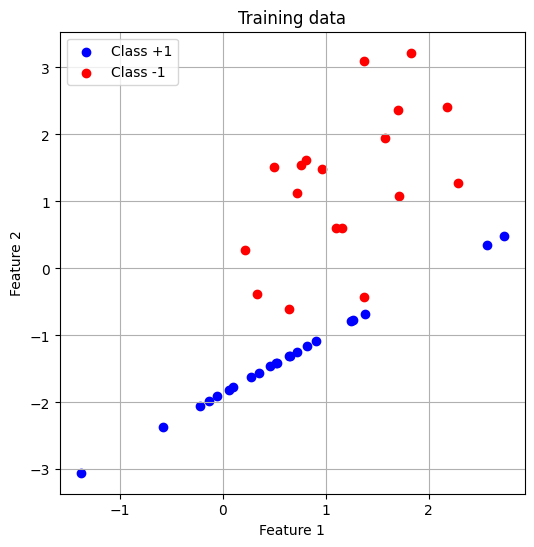

In [115]:
import matplotlib.pyplot as plt

def plot_dataset(suptitle, features, labels):
    # Separate points by class
    class_pos = features[labels == 1]
    class_neg = features[labels == -1]

    plt.figure(figsize=(6, 6))
    plt.scatter(class_pos[:, 0], class_pos[:, 1], color='blue', label='Class +1')
    plt.scatter(class_neg[:, 0], class_neg[:, 1], color='red', label='Class -1')
    plt.title(suptitle)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_dataset('Training data', train_x, train_labels)


## Perceptron

Since perceptron is a binary classifier, for each input vector $x$ the output of our perceptron would be either +1 or -1, depending on the class. The output will be computed using the formula

$$y(\mathbf{x}) = f(\mathbf{w}^{\mathrm{T}}\mathbf{x})$$

where $\mathbf{w}$ is a weight vector, $f$ is a step activation function:
$$
f(x) = \begin{cases}
         +1 & x \geq 0 \\
         -1 & x < 0
       \end{cases} \\
$$

However, a generic linear model should also have a bias, i.e. ideally we should compute $y$ as $y=f(\mathbf{w}^{\mathrm{T}}\mathbf{x}+\mathbf{b})$. To simplify our model, we can get rid of this bias term by adding one more dimension to our input features, which always equals to 1:

In [116]:
# Add bias term (column of ones) to training features
train_x_augmented = np.hstack([train_x, np.ones((train_x.shape[0], 1))])

# TODO: create an array of positive examples
pos_examples = train_x_augmented[train_labels == 1]

# TODO: create an array of negative examples
neg_examples = train_x_augmented[train_labels == -1]

print(pos_examples[0:3])


[[ 0.71705908 -1.2435981   1.          1.        ]
 [-1.38041556 -3.05007172  1.          1.        ]
 [ 0.46228075 -1.46318078  1.          1.        ]]


## Training Algorithm

In order to train the perceptron, we need to find out weights $\mathbf{w}$ that will minimize the error. The error is defined using **perceptron criteria**:

$$E(\mathbf{w}) = -\sum_{n \in \mathcal{M}}\mathbf{w}^{\mathrm{T}}\mathbf{x}_{n}t_{n}$$

  * $t_{n} \in \{-1, +1\}$ for negative and positive training samples, respectively
  * $\mathcal{M}$ - a set of wrongly classified examples
  
We will use the process of **gradient descent**. Starting with some initial random weights $\mathbf{w}^{(0)}$, we will adjust weights on each step of the training using the gradient of $E$:

$$\mathbf{w}^{\tau + 1}=\mathbf{w}^{\tau} - \eta \nabla E(\mathbf{w}) = \mathbf{w}^{\tau} + \eta\sum_{n \in \mathcal{M}}\mathbf{x}_{n} t_{n}$$

where $\eta$ is a **learning rate**, and $\tau\in\mathbb{N}$ - number of iteration.

Let's define this algorithm in Python:

In [117]:
class SimplePerceptron:
    def __init__(self, positive_examples, negative_examples, report_frequency=10):
        """
        Initialize the SimplePerceptron.

        :param report_frequency: How often (in epochs) we want to report accuracy.
        :param positive_examples: Numpy array of shape (num_pos_samples, num_features)
                                 containing all positive samples.
        :param negative_examples: Numpy array of shape (num_neg_samples, num_features)
                                 containing all negative samples.
        """
        self.n_features = positive_examples.shape[1]
        self.positive_examples = positive_examples
        self.negative_examples = negative_examples
        self.report_frequency = report_frequency
        self.weights = np.zeros((self.n_features, 1))  # TODO: initialize weights if needed

    def train(self, epochs=100):
        """
        Train the SimplePerceptron on positive and negative examples for a given number of epochs.

        :param epochs: Number of epochs to train.
        """
        # TODO: Determine the dimensionality from self.positive_examples (num_dims)
        num_dims = self.n_features  # 📣

        # TODO: If self.weights is None, initialize it to zeros of shape (num_dims, 1)
        if self.weights is None:
            self.weights = np.zeros((self.n_features, 1))

        # TODO: Get counts of positive (pos_count) and negative (neg_count) examples
        pos_count = self.positive_examples.shape[0]
        neg_count = self.negative_examples.shape[0]

        for epoch in range(epochs):
            # TODO: pick one positive example (pos) at random from self.positive_examples
            pos_idx = np.random.randint(pos_count)
            pos = self.positive_examples[pos_idx, :].reshape(-1, 1)  # 📣

            # TODO: pick one negative example (neg) at random from self.negative_examples
            neg_idx = np.random.randint(neg_count)
            neg = self.negative_examples[neg_idx, :].reshape(-1, 1)

            # TODO: compute z_pos
            z_pos = np.dot(self.weights.T, pos)    # 📣

            # TODO: if z_pos < 0, update self.weights   # 📣
            if z_pos<0:
                self.weights += pos

            # TODO: compute z_neg = dot product of neg with self.weights
            z_neg = np.dot(self.weights.T, neg)

            # TODO: if z_neg >= 0, update self.weights
            if z_neg >= 0:
                self.weights -= neg

            # TODO: every report_frequency epochs, compute accuracy and print   # 📣
            if epoch % self.report_frequency == 0:
                TP = TN = 0
                for pos_idx, pos in enumerate(self.positive_examples):
                    z = np.dot(self.weights.T, pos.reshape(-1, 1))
                    if z >= 0:
                        TP += 1
                for neg_idx, neg in enumerate(self.negative_examples):
                    z = np.dot(self.weights.T, neg.reshape(-1, 1))
                    if z < 0:
                        TN += 1

            accuracy = (TP + TN) / (pos_count + neg_count)
            print(f"Epoch {epoch}: Accuracy = {accuracy * 100:.2f}%")

        return self.weights


Now let's run the training on our dataset:

In [118]:
SimplePerceptron = SimplePerceptron(pos_examples,neg_examples)
wts = SimplePerceptron.train(100)

Epoch 0: Accuracy = 62.50%
Epoch 1: Accuracy = 62.50%
Epoch 2: Accuracy = 62.50%
Epoch 3: Accuracy = 62.50%
Epoch 4: Accuracy = 62.50%
Epoch 5: Accuracy = 62.50%
Epoch 6: Accuracy = 62.50%
Epoch 7: Accuracy = 62.50%
Epoch 8: Accuracy = 62.50%
Epoch 9: Accuracy = 62.50%
Epoch 10: Accuracy = 87.50%
Epoch 11: Accuracy = 87.50%
Epoch 12: Accuracy = 87.50%
Epoch 13: Accuracy = 87.50%
Epoch 14: Accuracy = 87.50%
Epoch 15: Accuracy = 87.50%
Epoch 16: Accuracy = 87.50%
Epoch 17: Accuracy = 87.50%
Epoch 18: Accuracy = 87.50%
Epoch 19: Accuracy = 87.50%
Epoch 20: Accuracy = 87.50%
Epoch 21: Accuracy = 87.50%
Epoch 22: Accuracy = 87.50%
Epoch 23: Accuracy = 87.50%
Epoch 24: Accuracy = 87.50%
Epoch 25: Accuracy = 87.50%
Epoch 26: Accuracy = 87.50%
Epoch 27: Accuracy = 87.50%
Epoch 28: Accuracy = 87.50%
Epoch 29: Accuracy = 87.50%
Epoch 30: Accuracy = 90.00%
Epoch 31: Accuracy = 90.00%
Epoch 32: Accuracy = 90.00%
Epoch 33: Accuracy = 90.00%
Epoch 34: Accuracy = 90.00%
Epoch 35: Accuracy = 90.00%
Ep

As you can see, initial accuracy is around 50%, but it quickly increases to higher values close to 90%.

Let's visualize how classes are separated. Our classification function looks like $\mathbf{w}^Tx$, and it is greater than 0 for one class, and is below 0 for another. Thus, class separation line is defined by $\mathbf{w}^Tx = 0$. Since we have only two dimensions $x_0$ and $x_1$, the equation for the line would be $w_0x_0+w_1x_1+w_2 = 0$ (remember that we have explicitly defined an extra dimension $x_2=1$). Let's plot this line:

In [119]:
def plot_boundary(positive_examples, negative_examples, weights):
    if np.isclose(weights[1], 0):
        if np.isclose(weights[0], 0):
            x = y = np.array([-6, 6], dtype = 'float32')
        else:
            y = np.array([-6, 6], dtype='float32')
            x = -(weights[1] * y + weights[2])/weights[0]
    else:
        x = np.array([-6, 6], dtype='float32')
        y = -(weights[0] * x + weights[2])/weights[1]

    pylab.xlim(-6, 6)
    pylab.ylim(-6, 6)
    pylab.plot(positive_examples[:,0], positive_examples[:,1], 'bo')
    pylab.plot(negative_examples[:,0], negative_examples[:,1], 'ro')
    pylab.plot(x, y, 'g', linewidth=2.0)
    pylab.show()

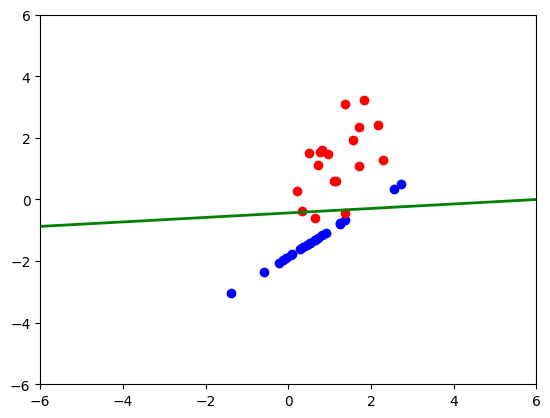

In [120]:
plot_boundary(pos_examples,neg_examples,wts)

## Evaluate on Test Dataset

In the beginning, we have put apart some data to the test dataset. Let's see how accurate our classifier is on this test dataset. In order to do this, we also expand the test dataset with an extra dimension, multiply by weights matrix, and make sure that the obtained value is of the same sign as the label (+1 or -1). We then add together all boolean values and divide by the length of test sample, to obtain the accuracy:

In [121]:
def accuracy(weights, test_x, test_labels):
    # Add bias term (i.e., column of 1s) to the test features
    ones = np.ones((test_x.shape[0], 1), dtype=np.float32)
    test_x_augmented = np.hstack((test_x, ones))

    # Compute predictions: w^T * x
    preds = np.dot(test_x_augmented, weights).flatten()

    # Check if predictions have the same sign as the true labels
    correct = np.sign(preds) == test_labels

    # Compute accuracy
    return np.mean(correct)


accuracy(wts, test_x, test_labels)

np.float64(0.8)

## Observing the training process

We have seen before how the accuracy decreases during training. It would be nice to see how the separation line behaves during training. The code below will visualize everything on one graph, and you should be able to move the slider to "time-travel" through the training process.

In [122]:
class PerceptronTrainerGraph:
    def __init__(self, report_frequency=15):
        """
        Initializes the PerceptronTrainerGraph.

        :param report_frequency: How often to record snapshots during training.
        """
        self.report_frequency = report_frequency
        self.weights = None
        self.snapshots = []

    def train(self, positive_examples, negative_examples, num_iterations=100):
        """
        Trains the perceptron and stores snapshots of its performance.

        :param positive_examples: Numpy array of shape (num_positive, num_features).
        :param negative_examples: Numpy array of shape (num_negative, num_features).
        :param num_iterations:   Number of training iterations.
        :return:                 Numpy array of snapshots, where each snapshot includes
                                 the weights and a small list storing accuracy metrics.
        """
        # TODO: Determine the number of dimensions from positive_examples/negative_examples
        pos_count, num_dims = positive_examples.shape
        neg_count, num_dims = negative_examples.shape


        # TODO: If self.weights is None, initialize it to zeros
        self.weights = np.zeros((num_dims, 1))

        # TODO: Store snapshots in a list
        snapshots = []

        epochs = num_iterations
        for epoch in range(epochs):
            # TODO: pick one positive example (pos) at random from self.positive_examples
            pos_idx = np.random.randint(pos_count)
            pos = positive_examples[pos_idx, :].reshape(-1, 1)

            # TODO: pick one negative example (neg) at random from self.negative_examples
            neg_idx = np.random.randint(neg_count)
            neg = negative_examples[neg_idx, :].reshape(-1, 1)

            z_pos = np.dot(self.weights.T, pos)
            if z_pos<0:
                self.weights += pos

            z_neg = np.dot(self.weights.T, neg)
            if z_neg >= 0:
                self.weights -= neg

            if epoch % self.report_frequency == 0:
                TP = TN = 0
                for pos_idx, pos in enumerate(positive_examples):
                    z = np.dot(self.weights.T, pos.reshape(-1, 1))
                    if z >= 0:
                        TP += 1
                for neg_idx, neg in enumerate(negative_examples):
                    z = np.dot(self.weights.T, neg.reshape(-1, 1))
                    if z < 0:
                        TN += 1

                accuracy = (TP + TN) / (pos_count + neg_count)
                snapshots_data = [self.weights.copy(), accuracy]
                self.snapshots.append(snapshots_data)



        return self.snapshots

    def plot(self, pos_examples, neg_examples, step, plot_boundary_function):
        """
        Plots the decision boundary at a specific training 'step', as well as
        the recorded accuracy over training snapshots.

        :param pos_examples:           Numpy array of positive examples.
        :param neg_examples:           Numpy array of negative examples.
        :param step:                   Index in self.snapshots to visualize.
        :param plot_boundary_function: A function that draws the decision boundary,
                                       e.g. the user's existing 'plot_boundary' method.
        """
        if self.snapshots is None:
            raise ValueError("No snapshots to plot. Make sure to call train() first.")
        if step < 0 or step >= len(self.snapshots):
            raise IndexError(f"Step must be between 0 and {len(self.snapshots)-1}.")
        fig = pylab.figure(figsize=(10, 4))

        # TODO: create a figure with two subplots (decision boundary and accuracy)
        ax1 = fig.add_subplot(1, 2, 1)

        # TODO: call plot_boundary_function with the appropriate weights from self.snapshots
        plot_boundary_function(pos_examples, neg_examples, self.snapshots[step][0])

        ax1.set_title(f"Decision Boundary at step={step}")


        ax2 = fig.add_subplot(1, 2, 2)
        # TODO: plot accuracy over snapshots, mark the chosen step
        accuracies = [snapshot[1] for snapshot in self.snapshots] #TODO
        ax2.plot(np.arange(len(accuracies)), accuracies, label='Accuracy') #TODO
        ax2.plot(step, accuracies[step], 'bo')
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Snapshot Index')
        ax2.set_title("Accuracy Over Snapshots")


trainer = PerceptronTrainerGraph(report_frequency=15)
snapshots = trainer.train(pos_examples, neg_examples, num_iterations=100)

def plotit(pos_examples,neg_examples,snapshots,step):
    fig = pylab.figure(figsize=(10,4))
    fig.add_subplot(1, 2, 1)
    plot_boundary(pos_examples, neg_examples, snapshots[step][0])
    fig.add_subplot(1, 2, 2)
    # pylab.plot(np.arange(len(snapshots[:,1])), snapshots[:,1])
    # pylab.ylabel('Accuracy')
    # pylab.xlabel('Iteration')
    # pylab.plot(step, snapshots[step,1][0], "bo")
    pylab.show()
def pl1(step): plotit(pos_examples,neg_examples,snapshots,step)


In [123]:
interact(pl1, step=widgets.IntSlider(value=0, min=0, max=len(snapshots)-1))

interactive(children=(IntSlider(value=0, description='step', max=6), Output()), _dom_classes=('widget-interact…

<function __main__.pl1(step)>

## Limitations of the Perceptron

As you have seen above, perceptron is a **linear classifier**. It can distinguish between two classes well if they are **linearly separable**, i.e. can be separated by a straight line. Otherwise, perceptron training process will not converge.

A most obvious example of a problem that cannot be solved by a perceptron is so-called **XOR problem**. We want our perceptron to learn the XOR boolean function.

Let's try and do that! We will manually populate all positive and negative training samples, and then call our train function defined above:

In [124]:
# TODO: Define XOR positive examples
pos_examples_xor = np.array([[0, 1, 1], [1, 0, 1]])

# TODO: Define XOR negative examples
neg_examples_xor = np.array([[0, 0, 1], [1, 1, 1]])

# TODO: Instantiate PerceptronTrainerGraph
trainer_xor = PerceptronTrainerGraph(report_frequency=10)

# TODO: Train the perceptron on XOR data
snapshots_xor = trainer_xor.train(pos_examples_xor, neg_examples_xor, num_iterations=100)

def pl2(step): plotit(pos_examples_xor,neg_examples_xor,snapshots_xor,step)


In [125]:
interact(pl2, step=widgets.IntSlider(value=0, min=0, max=len(snapshots)-1))

interactive(children=(IntSlider(value=0, description='step', max=6), Output()), _dom_classes=('widget-interact…

<function __main__.pl2(step)>

# Part2: Logistic Regression(20 points)

## Imports

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

# Enable inline plotting
%matplotlib inline

##Logistic Regression Theory

Logistic regression is a fundamental method for binary classification. It models the probability that an example belongs to a particular class using the **sigmoid** function:

$$ h_{\theta}(x) = \frac{1}{1+e^{-\theta^T x}} $$

The cost function used to train the model is given by:

$$ J(\theta) = -\frac{1}{m}\sum_{i=1}^{m}\Big[y^{(i)}\log(h_{\theta}(x^{(i)})) + (1-y^{(i)})\log(1-h_{\theta}(x^{(i)}))\Big] $$

We use **gradient descent** to iteratively update the parameters:

$$ \theta := \theta - \alpha \nabla J(\theta) $$



##Synthetic Binary Classification

In this experiment, we generate a **linearly separable** dataset using `make_classification`. We will pretend it’s analogous to a typical two-feature binary classification scenario. The dataset contains two features (X[:,0] and X[:,1]) and a binary target (y).

In [127]:
# TODO: Create a synthetic, linearly separable dataset
def load_data():
    """
    Create a synthetic, linearly separable dataset using make_classification.
    """
    X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_classes=2, random_state=7, class_sep=2)
    return X, y

# TODO: Load the synthetic dataset
X_train, y_train = load_data()  # e.g. load_data()

print("First five elements in X_train:")
print(X_train[:5])
print("First five elements in y_train:")
print(y_train[:5])
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Number of training examples:", len(y_train))

First five elements in X_train:
[[ 1.50123342 -2.06674029]
 [ 2.06816726 -1.42710861]
 [ 1.1934072  -0.84554422]
 [-3.85230985  0.25644664]
 [-1.75965463  1.7708333 ]]
First five elements in y_train:
[1 1 1 0 0]
Shape of X_train: (100, 2)
Shape of y_train: (100,)
Number of training examples: 100


### Visualizing the Data

Let's plot the two features. Here, points labeled `1` and `0` are marked differently.

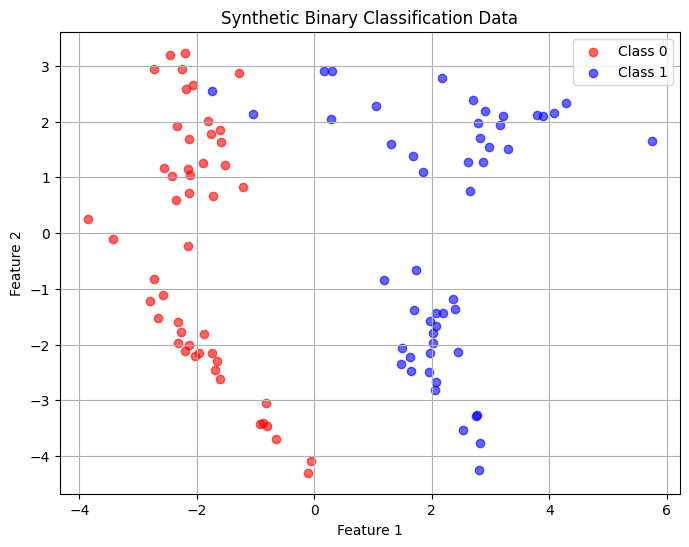

In [128]:
import matplotlib.pyplot as plt

def plot_data(X, y):
    """
    Plot the data points with different colors for different classes (0 and 1).

    Parameters:
    - X: ndarray, shape (n_samples, 2), the feature data
    - y: ndarray, shape (n_samples,), the target labels
    """
    plt.figure(figsize=(8, 6))

    # Plot points with label 0 in red
    plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', label='Class 0', alpha=0.6)

    # Plot points with label 1 in blue
    plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', label='Class 1', alpha=0.6)

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Synthetic Binary Classification Data')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot the synthetic dataset
plot_data(X_train, y_train)


### Logistic Regression Implementation

Below, we define the sigmoid function, the cost function, and the gradient descent algorithm to train our logistic regression model.

First five elements in X_train:
[[ 1.50123342 -2.06674029]
 [ 2.06816726 -1.42710861]
 [ 1.1934072  -0.84554422]
 [-3.85230985  0.25644664]
 [-1.75965463  1.7708333 ]]
First five elements in y_train:
[1 1 1 0 0]
Shape of X_train: (100, 2)
Shape of y_train: (100,)
Number of training examples: 100
Final cost: 0.08794222381388306


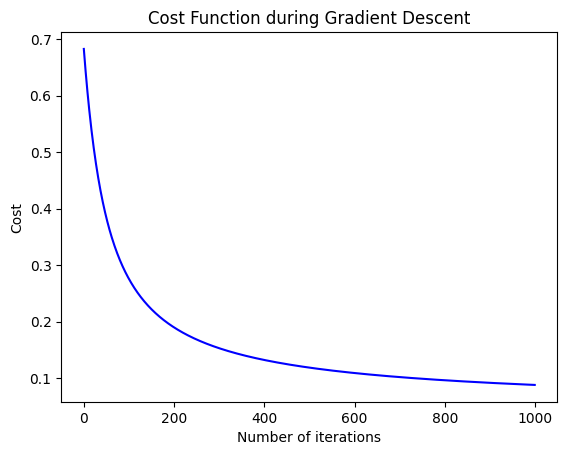

In [130]:
import numpy as np
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt

# Sigmoid function
def sigmoid(z):
    """
    Sigmoid function that maps any real-valued number to a value between 0 and 1.

    Parameters:
    - z: A scalar or vector of real numbers

    Returns:
    - The sigmoid function applied element-wise.
    """
    return 1 / (1 + np.exp(-z))

# Cost function
def compute_cost(theta, X, y):
    """
    Compute the cost function for logistic regression.

    Parameters:
    - theta: Model parameters
    - X: Feature matrix
    - y: True binary labels

    Returns:
    - cost: The logistic regression cost
    """
    m = len(y)  # number of training samples
    h = sigmoid(np.dot(X, theta))  # hypothesis

    # Cost function with regularization (without regularization in this case)
    epsilon = 1e-5  # to avoid log(0)
    cost = (-1 / m) * np.sum(y * np.log(h + epsilon) + (1 - y) * np.log(1 - h + epsilon))
    return cost

# Gradient descent function
def gradient_descent(X, y, theta, alpha, num_iters):
    """
    Perform gradient descent to minimize the cost function.

    Parameters:
    - X: Feature matrix
    - y: True binary labels
    - theta: Initial model parameters
    - alpha: Learning rate
    - num_iters: Number of iterations

    Returns:
    - theta: Final model parameters
    - cost_history: The cost at each iteration
    """
    m = len(y)  # number of training samples
    cost_history = []  # to store cost at each iteration

    for i in range(num_iters):
        h = sigmoid(np.dot(X, theta))  # hypothesis

        # Update the parameters (gradient descent)
        theta -= (alpha / m) * np.dot(X.T, (h - y))

        # Compute the cost and record it
        cost_history.append(compute_cost(theta, X, y))

    return theta, cost_history

# Create synthetic, linearly separable dataset
def load_data():
    """
    Create a synthetic, linearly separable dataset using make_classification.
    """
    X, y = make_classification(n_samples=100, n_features=2, n_informative=2, n_redundant=0, n_classes=2, random_state=7, class_sep=2)
    return X, y

# Load the synthetic dataset
X_train, y_train = load_data()

print("First five elements in X_train:")
print(X_train[:5])
print("First five elements in y_train:")
print(y_train[:5])
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Number of training examples:", len(y_train))

# Add intercept term (column of 1's) to X
X_train_with_intercept = np.c_[np.ones(X_train.shape[0]), X_train]

# Initialize theta to zeros
theta_initial = np.zeros(X_train_with_intercept.shape[1])

# Set hyperparameters
alpha = 0.01  # Learning rate
num_iters = 1000  # Number of iterations

# Run gradient descent
theta_final, cost_history = gradient_descent(X_train_with_intercept, y_train, theta_initial, alpha, num_iters)

# Print the final cost
print("Final cost:", cost_history[-1])

# Plot the cost history
plt.plot(range(num_iters), cost_history, color='blue')
plt.xlabel('Number of iterations')
plt.ylabel('Cost')
plt.title('Cost Function during Gradient Descent')
plt.show()


### Plotting the Decision Boundary

The decision boundary is given by the equation:

$$ \theta_0 + \theta_1 x_1 + \theta_2 x_2 = 0 $$

We plot this boundary along with the data.

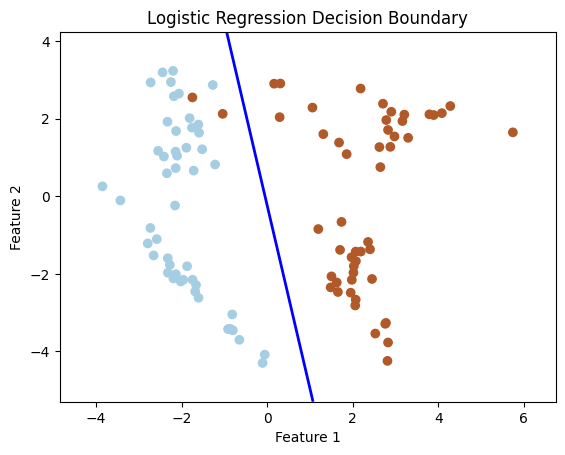

In [140]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot the decision boundary
def plot_decision_boundary(theta, X, y):
    """
    Plot the decision boundary for the logistic regression model along with the data points.

    Parameters:
    - theta: The learned model parameters.
    - X: The feature matrix with intercept term added.
    - y: The binary target labels.
    """
    # Generate a grid of points to plot the decision boundary
    x_min, x_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    y_min, y_max = X[:, 2].min() - 1, X[:, 2].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

    # Compute the decision boundary
    Z = sigmoid(np.c_[np.ones((xx.ravel().shape[0], 1)), xx.ravel(), yy.ravel()] @ theta)
    Z = Z.reshape(xx.shape)

    # Plot the data points and decision boundary
    plt.contour(xx, yy, Z, levels=[0.5], colors='blue', linestyles='-', linewidths=2)


    # Scatter plot of the data points
    plt.scatter(X[:, 1], X[:, 2], c=y, cmap=plt.cm.Paired)

    # Labels and title
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Logistic Regression Decision Boundary")

    plt.show()

# Plot the decision boundary for the learned model
plot_decision_boundary(theta_final, X_train_with_intercept, y_train)


### Evaluating the Model

We predict the class labels using a threshold of 0.5 and compute the training accuracy.

In [141]:
from sklearn.metrics import accuracy_score

# Sigmoid function (as previously defined)
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Prediction function using the threshold of 0.5
def predict(theta, X):
    return sigmoid(X.dot(theta)) >= 0.5

# Evaluate the training accuracy
predictions = predict(theta_final, X_train_with_intercept)
accuracy = accuracy_score(y_train, predictions)

# Display the result
print("Training accuracy: {:.2f}%".format(accuracy * 100))


Training accuracy: 98.00%


# Perceptron VS Logistic Regression(15 points)

In this note, we see the implementation of **Logistic Regression** and the **Perceptron** algorithm. Below are a few questions comparing these two methods, followed by concise answers for each.

---

### 1. How do Logistic Regression and the Perceptron differ in terms of their decision boundaries?

**Answer**:  

Logistic Regression and the Perceptron differ in their decision boundaries in that:

Logistic Regression creates a smooth, probabilistic decision boundary based on a sigmoid function, which outputs probabilities. It can handle cases where the classes are not perfectly linearly separable by adjusting the decision boundary with the logistic loss function.

Perceptron, on the other hand, creates a linear, non-probabilistic decision boundary that strictly separates the classes. It only outputs class labels and adjusts the boundary based on misclassified points during training, making it less flexible than logistic regression.


---

### 2. What are the key differences in the outputs of Logistic Regression and the Perceptron?

**Answer**:  

The key differences in the outputs of Logistic Regression and the Perceptron are:

1. **Probability vs. Class Label:**
   - **Logistic Regression** outputs **probabilities** for each class, which are values between 0 and 1. This allows for soft classification, where you can assess the confidence of the model in its predictions.
   - **Perceptron** outputs a **hard class label** (either 0 or 1) directly without providing any probability or confidence level.

2. **Decision Boundary:**
   - **Logistic Regression** produces a **smooth, probabilistic decision boundary** that can work well even when classes are not perfectly separable.
   - **Perceptron** generates a **linear decision boundary** based purely on the data it has seen, and it only adjusts when a misclassification occurs.

3. **Loss Function:**
   - **Logistic Regression** uses a **logistic loss** (cross-entropy) that measures the error between predicted probabilities and true labels.
   - **Perceptron** uses a **hinge loss** or a hard margin that focuses solely on the classification of each data point as either correct or incorrect, without considering confidence levels.
---

### 3. Under what conditions does the Perceptron converge, and how does this compare to Logistic Regression?

**Answer**:  

### Perceptron Convergence:
The Perceptron **converges** only if the data is **linearly separable**. If not, it may not converge and continue to update weights indefinitely.

### Logistic Regression Convergence:
Logistic Regression **converges** even with **non-linearly separable data**. It uses optimization methods (e.g., gradient descent) and can handle noisy or overlapping data.

### Key Comparison:
- **Perceptron** requires linear separability to converge.
- **Logistic Regression** can converge even with non-linearly separable data.
---

### 4. How does each algorithm handle misclassified examples?

**Answer**:  

### Perceptron:
The Perceptron updates its weights whenever it misclassifies an example. If a data point is misclassified, the weights are adjusted to move the decision boundary closer to the misclassified example.

### Logistic Regression:
Logistic Regression minimizes a **cost function** that accounts for misclassified examples by penalizing them. However, it does not adjust weights directly for each misclassified example. Instead, it tries to minimize the overall error across all examples using **gradient descent**.

### Key Comparison:
- **Perceptron** adjusts weights directly for each misclassified example.
- **Logistic Regression** minimizes overall error, making updates less directly tied to individual misclassified examples.


---

### 5. How do the two algorithms behave when the data is not linearly separable?

**Answer**:  

### Perceptron:
When the data is **not linearly separable**, the Perceptron algorithm **fails to converge**. It keeps updating its weights without ever reaching a stable solution, because it will continue to misclassify examples indefinitely.

### Logistic Regression:
Logistic Regression can still perform reasonably well even when the data is **not linearly separable**. It doesn't rely on perfect separation but rather tries to find a decision boundary that minimizes the overall error. It will converge to a solution, but the decision boundary may not be perfectly accurate, especially if the data has significant overlap between the classes.

### Key Comparison:
- **Perceptron** does not converge if the data is not linearly separable.
- **Logistic Regression** still converges and provides a probabilistic decision boundary even with non-separable data.

---
